# Предсказание победителя в Dota 2

Kaggle: 0.82245

Карту можно условно разделить по главной диагонали на две половины (Radiant и Dire). У каждой команды есть главное здание (трон), которое необходимо разрушить, чтобы победить. Ничьих в Доте не бывает, поэтому матчи иногда могут быть весьма долгие. На пути к трону по трем линиям стоят вышки, разрушение которых также является очень важным аспектом игры. Подробнее об остальных аспектах игры будет написано в статье, ссылка на которую находится в базовом ноутбуке.

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [2]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import ExtraTreesClassifier

%matplotlib inline

In [180]:
import numpy as np

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb # сначала ее установила через conda
from sklearn.linear_model import LogisticRegression

In [4]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [5]:
PATH_TO_DATA = "bi-2021-ml-competitions-dota2"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [6]:
df_train_features.shape

(31698, 245)

In [7]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [8]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [172]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [173]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [174]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

Wall time: 9.91 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

# Используем другую модель -  Decision Tree Classifier

In [57]:
dt_model = DecisionTreeClassifier(random_state=SEED, max_depth=7)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=10801)

In [58]:
y_pred_dt = dt_model.predict_proba(X_valid)[:, 1]

In [59]:
valid_score = roc_auc_score(y_valid, y_pred_dt)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.6944019795260108


In [60]:
valid_accuracy = accuracy_score(y_valid, y_pred_dt > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6363827549947424


# Сдедующая -  With Extra Trees Classifier

In [61]:
de_model = ExtraTreesClassifier(random_state=SEED, max_depth=7)
de_model.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=7, random_state=10801)

In [62]:
y_pred_de = de_model.predict_proba(X_valid)[:, 1]

In [63]:
valid_score = roc_auc_score(y_valid, y_pred_de)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7677797841620179


# Gradient Boosting

In [194]:
gb_model = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1,
                                        max_features='log2', max_depth=7,
                                        random_state=1)

In [195]:
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=7, max_features='log2', n_estimators=500,
                           random_state=1)

In [86]:
y_pred_gb = gb_model.predict_proba(X_valid)[:, 1]

In [87]:
valid_score = roc_auc_score(y_valid, y_pred_gb)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7927414836883268


# Lightgbm model

In [211]:
lgb_model = lgb.LGBMClassifier(learning_rate=0.12, max_depth=7, random_state=SEED)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict_proba(X_valid)[:, 1]
valid_score = roc_auc_score(y_valid, y_pred_lgb)
print("ROC-AUC score на отложенной части:", valid_score)
valid_accuracy = accuracy_score(y_valid, y_pred_lgb > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

ROC-AUC score на отложенной части: 0.7909493532559659
Accuracy score (p > 0.5) на отложенной части: 0.7093585699263932


# LogisticRegression

In [218]:
lr = LogisticRegression(random_state=SEED)

lr.fit(X_train, y_train)
y_pred_lr = lr.predict_proba(X_valid)[:, 1]
valid_score = roc_auc_score(y_valid, y_pred_lr)
print("ROC-AUC score на отложенной части:", valid_score)
valid_accuracy = accuracy_score(y_valid, y_pred_lr > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

ROC-AUC score на отложенной части: 0.806519941614396
Accuracy score (p > 0.5) на отложенной части: 0.7171398527865405


#### Сделаем предсказания и оценим качество на отложенной части данных

Возвращаясь к random forest:

In [15]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [16]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [13]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [17]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [15]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-26_15-03-34.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [155]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [157]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

Wall time: 1min 1s


In [158]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [21]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [22]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [30]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [22]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

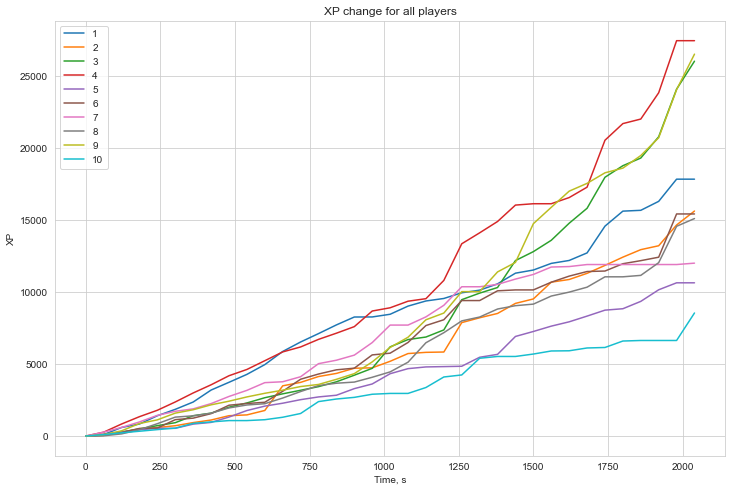

In [23]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [267]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):  #31698
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [284]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']
        
        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # Считаем количество Roshan kills обеими командами
        radiant_roshan_kills = 0
        dire_roshan_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_ROSHAN_KILL":
                if objective["team"] == 2:
                    radiant_roshan_kills += 1
                if objective["team"] == 3:
                    dire_roshan_kills += 1

        df_features.loc[match_id_hash, "radiant_roshan_kills"] = radiant_roshan_kills
        df_features.loc[match_id_hash, "dire_roshan_kills"] = dire_roshan_kills
        df_features.loc[match_id_hash, "diff_roshan_kills"] = radiant_roshan_kills - dire_roshan_kills
        
        
        # Считаем количество всех использованных вещей по каждой команде
        # Если три цифры в айди, то dire
        items_used_r = 0
        items_used_d = 0
        for i in match["players"]:
            if i["player_slot"] < 100:
                for j in i["item_uses"]:
                    items_used_r += i["item_uses"][j]
            else:
                for j in i["item_uses"]:
                    items_used_d += i["item_uses"][j]
        df_features.loc[match_id_hash, "items_used_d"] = items_used_d
        df_features.loc[match_id_hash, "items_used_r"] = items_used_r
        df_features.loc[match_id_hash, "items_used_diff"] = items_used_d - items_used_r
        
        # И количество вообще всех использованных способностей по каждой команде
        
        ability_used_r = 0
        ability_used_d = 0
        for n in match["players"]:
            if n["player_slot"] < 100:
                for l in n["ability_uses"]:
                    ability_used_r += n["ability_uses"][l]
            else:
                for l in n["ability_uses"]:
                    ability_used_d += n["ability_uses"][l]
        df_features.loc[match_id_hash, "ability_used_d"] = ability_used_d
        df_features.loc[match_id_hash, "ability_used_r"] = ability_used_r
        df_features.loc[match_id_hash, "ability_used_diff"] = ability_used_d - ability_used_r
        
        # И всего использованного золота по каждой команде
        
        gold_r = 0
        gold_d = 0
        for m in match["players"]:
            if m["player_slot"] < 100:
                gold_r += m["gold"]
            else:
                gold_d += m["gold"]
        df_features.loc[match_id_hash, "gold_d"] = gold_d
        df_features.loc[match_id_hash, "gold_r"] = gold_r
        df_features.loc[match_id_hash, "gold_diff"] = gold_d - gold_r
        
        # Количество совершенных покупок
        purchase_r = 0
        purchase_d = 0
        for n in match["players"]:
            if n["player_slot"] < 100:
                for l in n["purchase"]:
                    purchase_r += n["purchase"][l]
            else:
                for l in n["purchase"]:
                    purchase_d += n["purchase"][l]
        df_features.loc[match_id_hash, "purchase_d"] = purchase_d
        df_features.loc[match_id_hash, "purchase_r"] = purchase_r
        df_features.loc[match_id_hash, "purchase_diff"] = purchase_d - purchase_r
        
        # Урон
        
        damage_r = 0
        damage_d = 0
        for d in match["players"]:
            if d["player_slot"] < 100:
                for l in d["damage"]:
                    damage_r += d["damage"][l]
            else:
                for l in d["damage"]:
                    damage_d += d["damage"][l]
        df_features.loc[match_id_hash, "damage_d"] = damage_d
        df_features.loc[match_id_hash, "damage_r"] = damage_r
        df_features.loc[match_id_hash, "damage_diff"] = damage_d - damage_r
        
        # kills
        kills_r = 0
        kills_d = 0
        for d in match["players"]:
            if d["player_slot"] < 100:
                kills_r += d["kills"]
            else:
                kills_d += d["kills"]
        df_features.loc[match_id_hash, "kills_d"] = kills_d
        df_features.loc[match_id_hash, "kills_r"] = kills_r
        df_features.loc[match_id_hash, "kills_diff"] = kills_d - kills_r
        
        # hero hits
        hero_hits_r = 0
        hero_hits_d = 0
        for d in match["players"]:
            if d["player_slot"] < 100:
                for l in d["hero_hits"]:
                    hero_hits_r += d["hero_hits"][l]
            else:
                for l in d["hero_hits"]:
                    hero_hits_d += d["hero_hits"][l]
        df_features.loc[match_id_hash, "hero_hits_d"] = hero_hits_d
        df_features.loc[match_id_hash, "hero_hits_r"] = hero_hits_r
        df_features.loc[match_id_hash, "hero_hits_diff"] = hero_hits_d - hero_hits_r
        

In [285]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

In [286]:
df_train_features_extended.head(10)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,purchase_diff,damage_d,damage_r,damage_diff,kills_d,kills_r,kills_diff,hero_hits_d,hero_hits_r,hero_hits_diff
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,-17.0,46818.0,69765.0,-22947.0,3.0,16.0,-13.0,790.0,308.0,482.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,-3.0,68.0,70.0,-2.0,0.0,0.0,0.0,1.0,1.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,-5.0,8773.0,5345.0,3428.0,0.0,0.0,0.0,38.0,46.0,-8.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,-16.0,90519.0,119781.0,-29262.0,11.0,9.0,2.0,526.0,578.0,-52.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,3.0,56750.0,57878.0,-1128.0,10.0,6.0,4.0,539.0,260.0,279.0
df50f738c454d430a33b2bf90cb9ef1a,636,22,7,1,5,74,1,1,0,3,...,-4.0,71453.0,45306.0,26147.0,7.0,2.0,5.0,500.0,688.0,-188.0
7469e9440ea3d19b211a484647c7126e,1054,22,0,8,5,71,1,3,10,4,...,-14.0,120648.0,113237.0,7411.0,11.0,14.0,-3.0,789.0,430.0,359.0
0aa1c6d7630433a93fe42da5ac810368,1797,22,7,9,2,35,1,5,2,1,...,-6.0,365237.0,279784.0,85453.0,35.0,21.0,14.0,912.0,1737.0,-825.0
892b5d40992e4b334e159f99b2bb55e6,605,22,7,0,5,30,0,1,3,1,...,-7.0,50743.0,61519.0,-10776.0,3.0,7.0,-4.0,178.0,263.0,-85.0


In [287]:
df_train_features_extended["r_kills"] = df_train_features_extended["r1_kills"]+df_train_features_extended["r2_kills"] + df_train_features_extended["r3_kills"] + df_train_features_extended["r4_kills"] + df_train_features_extended["r5_kills"] 
df_train_features_extended["d_kills"] = df_train_features_extended["d1_kills"]+df_train_features_extended["d2_kills"] + df_train_features_extended["d3_kills"] + df_train_features_extended["d4_kills"] + df_train_features_extended["d5_kills"] 

In [288]:
df_train_features_extended["r_assists"] = df_train_features_extended["r1_assists"]+df_train_features_extended["r2_assists"] + df_train_features_extended["r3_assists"] + df_train_features_extended["r4_assists"] + df_train_features_extended["r5_assists"]
df_train_features_extended["d_assists"] = df_train_features_extended["d1_assists"]+df_train_features_extended["d2_assists"] + df_train_features_extended["d3_assists"] + df_train_features_extended["d4_assists"] + df_train_features_extended["d5_assists"] 

In [289]:
df_train_features_extended["r_deaths"] = df_train_features_extended["r1_deaths"]+df_train_features_extended["r2_deaths"] + df_train_features_extended["r3_deaths"] + df_train_features_extended["r4_deaths"] + df_train_features_extended["r5_deaths"]
df_train_features_extended["d_deaths"] = df_train_features_extended["d1_deaths"]+df_train_features_extended["d2_deaths"] + df_train_features_extended["d3_deaths"] + df_train_features_extended["d4_deaths"] + df_train_features_extended["d5_deaths"] 

In [290]:
df_train_features_extended["d_kda"] = 1/df_train_features_extended["d_deaths"]*(df_train_features_extended["d_kills"] + df_train_features_extended["d_assists"])
df_train_features_extended["r_kda"] = 1/df_train_features_extended["r_deaths"]*(df_train_features_extended["r_kills"] + df_train_features_extended["r_assists"])

In [291]:
df_train_features_extended['d_kda'] = df_train_features_extended['d_kda'].fillna(df_train_features_extended['d_kda'].median())
df_train_features_extended['r_kda'] = df_train_features_extended['r_kda'].fillna(df_train_features_extended['r_kda'].median())
df_train_features_extended['d_kda'] = df_train_features_extended['d_kda'].replace([np.inf, -np.inf], df_train_features_extended['d_kda'].median())
df_train_features_extended['r_kda'] = df_train_features_extended['r_kda'].replace([np.inf, -np.inf], df_train_features_extended['r_kda'].median())
df_train_features_extended["dif_kda"] = df_train_features_extended["r_kda"] - df_train_features_extended["d_kda"]

In [275]:
df_train_features_extended.head(10)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,damage_diff,r_kills,d_kills,r_assists,d_assists,r_deaths,d_deaths,d_kda,r_kda,dif_kda
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,-22947.0,16,3,14,3,4,16,0.375000,7.500000,7.125000
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,-2.0,0,0,0,0,0,0,2.285714,2.300000,0.014286
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,3428.0,0,0,0,0,0,0,2.285714,2.300000,0.014286
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,-29262.0,9,11,12,13,12,10,2.400000,1.750000,-0.650000
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,-1128.0,6,10,7,10,10,6,3.333333,1.300000,-2.033333
df50f738c454d430a33b2bf90cb9ef1a,636,22,7,1,5,74,1,1,0,3,...,26147.0,2,7,6,8,7,3,5.000000,1.142857,-3.857143
7469e9440ea3d19b211a484647c7126e,1054,22,0,8,5,71,1,3,10,4,...,7411.0,14,11,23,25,11,14,2.571429,3.363636,0.792208
0aa1c6d7630433a93fe42da5ac810368,1797,22,7,9,2,35,1,5,2,1,...,85453.0,21,35,31,42,35,22,3.500000,1.485714,-2.014286
892b5d40992e4b334e159f99b2bb55e6,605,22,7,0,5,30,0,1,3,1,...,-10776.0,7,3,3,5,4,7,1.142857,2.500000,1.357143


In [168]:
#df_train_features_extended["gold_used"] = df_train_features_extended["gold_used"]/100000

In [292]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

Wall time: 1min 47s


In [293]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.8025614888256293


In [ ]:
# Lightgbm model

In [294]:
%%time
cv_scores_base = cross_val_score(lgb_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(lgb_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

Wall time: 24.6 s


In [295]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7897189731793569
ROC-AUC на кросс-валидации для новых признаков: 0.8086056192040468


In [ ]:
# Gradient Boosting

In [280]:
%%time
cv_scores_base = cross_val_score(gb_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(gb_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

Wall time: 3min 32s


In [281]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7960148172814197
ROC-AUC на кросс-валидации для новых признаков: 0.8049434255204966


In [ ]:
# Логистическая регрессия

In [296]:
%%time
cv_scores_base = cross_val_score(lr, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(lr, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

Wall time: 9.04 s


In [297]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.8078404566771574
ROC-AUC на кросс-валидации для новых признаков: 0.8091852199945355


In [300]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = lr.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_21-21-32.csv
